#### Рекомендательная система

Есть некоторый новостной сайт, на котором представлены разные статьи. Сейчас здесь нет какой-то серьезной рекомендательной системы, пользователю показываются все недавние статьи по популярности.  
На основе предоставленных данных, вам необходимо предсказать следующие 3 сайта, которые посетит каждый пользователь из тестового выборки. 

![](a.jpg)

In [356]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.pyplot import cm
import re
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

In [758]:
import time
from tqdm.notebook import tqdm
from sklearn import utils

In [769]:
import implicit

ImportError: cannot import name '_als' from partially initialized module 'implicit' (most likely due to a circular import) (C:\ProgramData\Anaconda3\lib\site-packages\implicit\__init__.py)

#### Загрузка и обработка данных

Обучающая выборка:

In [4]:
df_train = pd.read_csv(r'Data\train.csv', )
df_train.head()

,user_id,item_id,order
0,0,0,1
1,0,1,2
2,0,2,3
3,0,3,4
4,0,4,5


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705066 entries, 0 to 705065
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  705066 non-null  int64
 1   item_id  705066 non-null  int64
 2   order    705066 non-null  int64
dtypes: int64(3)
memory usage: 16.1 MB


Описания пользователя:

In [6]:
df_uf = pd.read_csv(r'Data\user-features.csv', )
df_uf.head()

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315


In [7]:
df_uf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  15000 non-null  int64  
 1   0        15000 non-null  float64
 2   1        15000 non-null  float64
 3   2        15000 non-null  float64
 4   3        15000 non-null  float64
 5   4        15000 non-null  float64
 6   5        15000 non-null  float64
 7   6        15000 non-null  float64
 8   7        15000 non-null  float64
 9   8        15000 non-null  float64
 10  9        15000 non-null  float64
 11  10       15000 non-null  float64
 12  11       15000 non-null  float64
 13  12       15000 non-null  float64
 14  13       15000 non-null  float64
 15  14       15000 non-null  float64
 16  15       15000 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 1.9 MB


In [8]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,0.058268,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,0.022782,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,-0.035558,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,0.022008,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300


Тестовая выборка:

In [9]:
df_test = pd.read_csv(r'Data\test.csv', )
df_test.head()

,user_id,order
0,0,1
1,0,2
2,0,3
3,1,1
4,1,2


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  45000 non-null  int64
 1   order    45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


Пропусков в данных нет, типы данных соответсвуют данным.

##### Визуализация данных

In [11]:
print("В нашей обучающей выборке ({}) уникальных пользователей и "\
      "({}) уникальных сйтов.".format(len(df_train["user_id"].unique()),
                                       len(df_train["item_id"].unique())))

В нашей обучающей выборке (15000) уникальных пользователей и (191) уникальных сйтов.


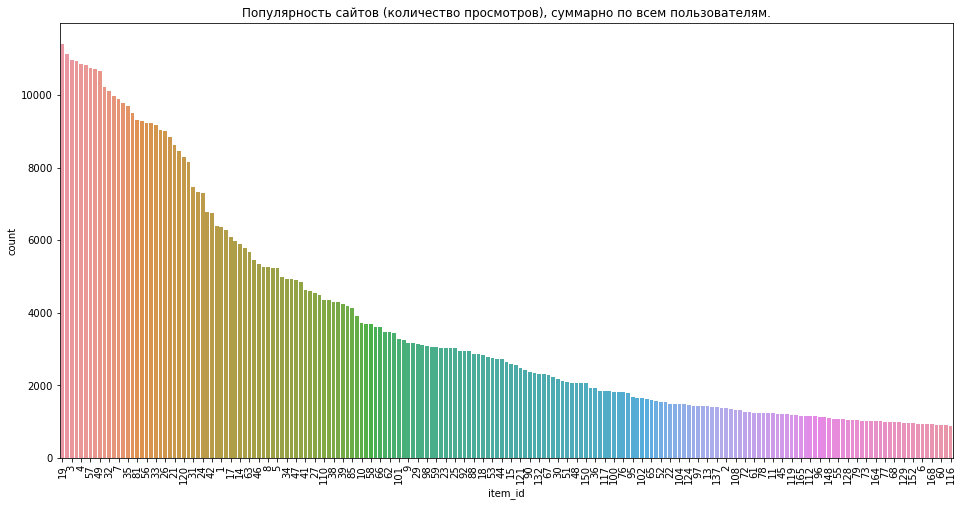

In [12]:
plt.figure(figsize=(16,8))
sns.countplot(data=df_train, x='item_id', order=df_train["item_id"].value_counts().index)
plt.title("Популярность сайтов (количество просмотров), суммарно по всем пользователям.")
plt.xticks(range(0,len(df_train["item_id"].unique()),2))
plt.xticks(rotation=90);

In [13]:
df_tt = pd.DataFrame(df_train.pivot_table(index='item_id', columns='order', aggfunc='count', fill_value=0).to_records())

In [14]:
df_tt.columns = list(range(0,66,1))
df_tt.drop(0, axis=1, inplace=True)

In [15]:
df_tt

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,23,54,90,47,38,33,43,39,32,28,...,7,5,4,2,1,0,0,0,1,0
1,158,242,228,265,218,189,218,247,236,225,...,13,11,7,3,4,2,0,0,0,0
2,40,54,64,79,64,57,45,54,58,56,...,11,8,4,3,0,2,0,0,0,0
3,241,344,329,299,286,289,321,304,282,315,...,19,8,7,0,2,1,0,0,0,0
4,223,290,282,290,275,285,294,288,286,276,...,18,9,9,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,14,10,18,21,22,10,10,15,27,21,...,0,1,2,0,0,1,0,0,0,0
187,14,35,27,25,19,32,20,22,27,21,...,5,3,3,4,0,0,0,0,0,0
188,16,41,13,21,10,15,16,21,11,15,...,2,0,1,2,2,1,1,0,0,0
189,5,13,21,19,20,7,19,12,18,26,...,5,3,3,3,1,1,0,0,0,0


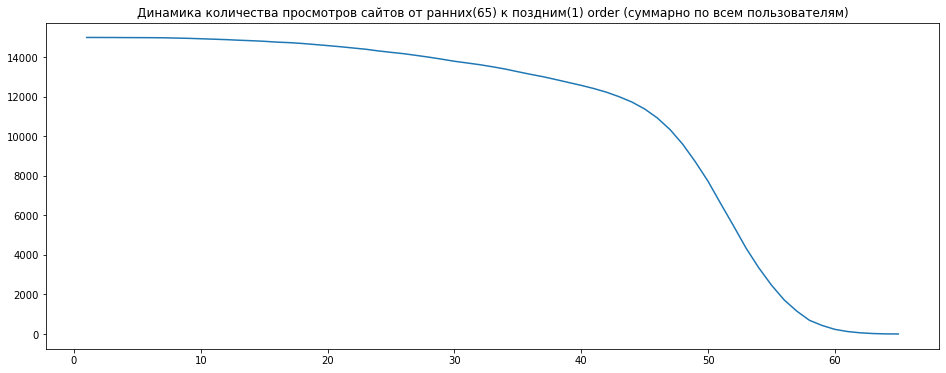

In [16]:
df_tt.sum().plot(figsize=(16,6))
plt.title("Динамика количества просмотров сайтов от ранних(65) к поздним(1) order (суммарно по всем пользователям)");

Сначала (65) количество просмотров было низким, затем оно резко возрасло. Возможно старые данные вообще не стоит использовать, а взять только последние 1-20-30.

In [17]:
df_tt[65].value_counts()

0    190
1      1
Name: 65, dtype: int64

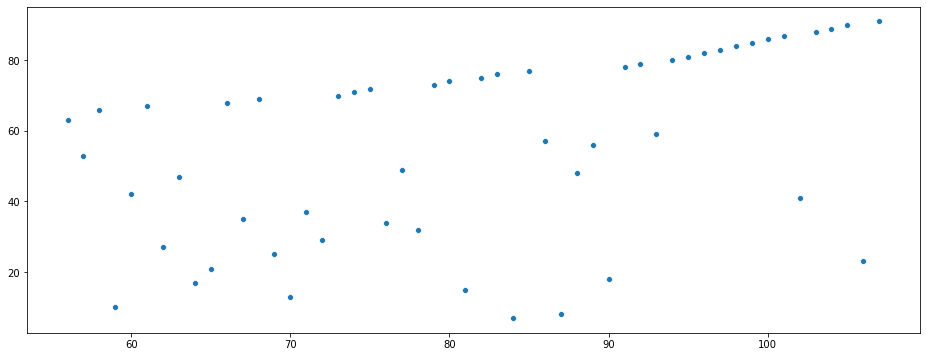

In [18]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=df_train[df_train['user_id'] == 1]['item_id'])

In [19]:
df_train[df_train['user_id'] == 14999]['item_id'].value_counts()

124    1
46     1
42     1
41     1
35     1
34     1
33     1
32     1
31     1
29     1
27     1
26     1
24     1
21     1
148    1
19     1
17     1
16     1
15     1
14     1
13     1
8      1
7      1
5      1
3      1
45     1
48     1
123    1
49     1
112    1
104    1
102    1
99     1
98     1
160    1
92     1
85     1
84     1
81     1
76     1
74     1
69     1
67     1
66     1
65     1
63     1
57     1
56     1
53     1
52     1
51     1
50     1
1      1
Name: item_id, dtype: int64

Можно добавить фичу - статьи которые он вообще не смотрел и получается вряд ли посмотрит

А есть ли пользователи, которые смотрели одни и теже сайты больше 1 раза?

In [20]:
df_item_gt1 = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='count', fill_value=0).to_records())

df_item_gt1.drop('user_id', axis=1, inplace=True)
df_item_gt1.columns = list(range(0,191,1))

df_item_gt1

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
14996,0,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,0,0,0,0,0,1,1,1,0,0,...,0,0,1,1,0,0,0,0,0,0
14998,0,0,0,1,0,0,1,1,1,0,...,1,0,0,0,0,0,1,0,0,0


In [21]:
df_item_gt1[df_item_gt1 >1].sum().sort_values(ascending=True)

0      0.0
121    0.0
122    0.0
123    0.0
124    0.0
      ... 
66     0.0
67     0.0
68     0.0
59     0.0
190    0.0
Length: 191, dtype: float64

In [22]:
for index, row in df_item_gt1.head().iterrows():
    if row.sort_values(ascending=False)[0] > 0:
        print(row.sort_values(ascending=False))

0      1
28     1
30     1
31     1
32     1
      ..
124    0
123    0
122    0
121    0
95     0
Name: 0, Length: 191, dtype: int64


Это говорит о том, что ни один пользователь не посмотрел один и тот же сайт дважды? Значит просмотренные сайты можно вообще исключить из прогноза для пользователя?

Есть пользователи, которые вообще ничего не смотрели?

In [23]:
df_item_gt1.sum(axis=1).sort_values()

1051      1
13272     2
3411      3
11196     3
344       3
         ..
5726     64
4046     64
11217    64
9914     64
1192     65
Length: 15000, dtype: int64

Возможно количество просмотров у каждого пользователя можно использовать как фичу

Выбрать пользователей у которых последние N просмотров нулевые

In [24]:
df_train[df_train['user_id'] == 13272]

,user_id,item_id,order
623204,13272,150,1
623205,13272,54,2


In [25]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,0.125555,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,-0.056245,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,-0.007334,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,0.094262,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,0.075146,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,0.058268,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,0.022782,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,-0.035558,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,0.022008,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300


### Разобью пользователей на кластеры

Прежде чем работать с метрическими алгоритмами нужно отмасштабировать данные.

In [26]:
scaler = MinMaxScaler(feature_range=(0,1)) 
df_uf_scaled = scaler.fit_transform(df_uf)

Понижаю размерность до 2 чтобы визуализировать текущие данные по пользователям

In [27]:
pca = PCA(n_components=2, random_state=42)

In [30]:
%%time
df_uf_pca = pca.fit_transform(df_uf_scaled )

Wall time: 142 ms


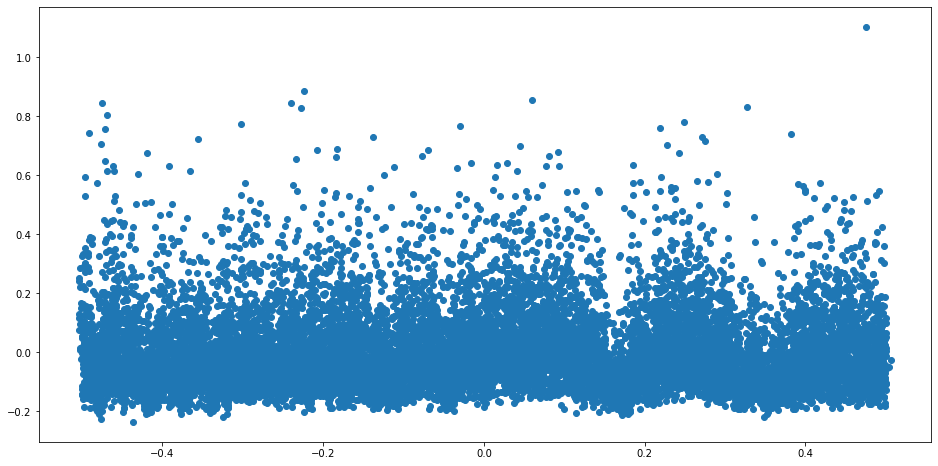

In [31]:
plt.figure(figsize=(16,8))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1])#,c=clf.labels_)

In [246]:
tsne = TSNE(n_components=2, init='pca', random_state=42)

In [247]:
%%time
X_reduced_tsne = tsne.fit_transform(df_uf)
print(X_reduced_tsne.shape)

KeyboardInterrupt: 

Определяю количество кластеров.

Метод коэффицинет силуэта

In [266]:
def draw_sil(X, range_n_clusters = [2, 3, 4, 5, 6]):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [267]:
def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 14, 15, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    plt.xticks(range(0, len(range_n_clusters)+1 , 1))
    plt.grid(alpha=0.35)
    return print('\n\n shape: {}, max_score_cluster: {}'.format(X.shape, range_n_clusters[np.argmax(scores)]))

In [268]:
def draw_sil_score_n_components(data, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 14, 15, 20], n_components=range(4,10)): 
    '''
    Строит графики очков коэффициента силуэта по всем РСА и всей выборке количества кластеров
    '''
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    i=0

    for row, row_axes in enumerate(axes):
      for column, ax in enumerate(row_axes):
        pca = PCA(n_components=n_components[i], random_state=42)
        X = pca.fit_transform(data)
        scores = []
        for n_clusters in range_n_clusters:
          clusterer = KMeans(n_clusters=n_clusters, random_state=10)
          cluster_labels = clusterer.fit_predict(X)
          silhouette_avg = silhouette_score(X, cluster_labels)
          scores.append(silhouette_avg)     
        ax.plot(range_n_clusters, scores)
        ax.set_xticks(range(0, len(range_n_clusters)+1 , 1))
        ax.set_title('shape: {}, max_score_cluster: {}'.format(X.shape, range_n_clusters[np.argmax(scores)]))
        ax.grid(alpha=0.35)

        i+=1

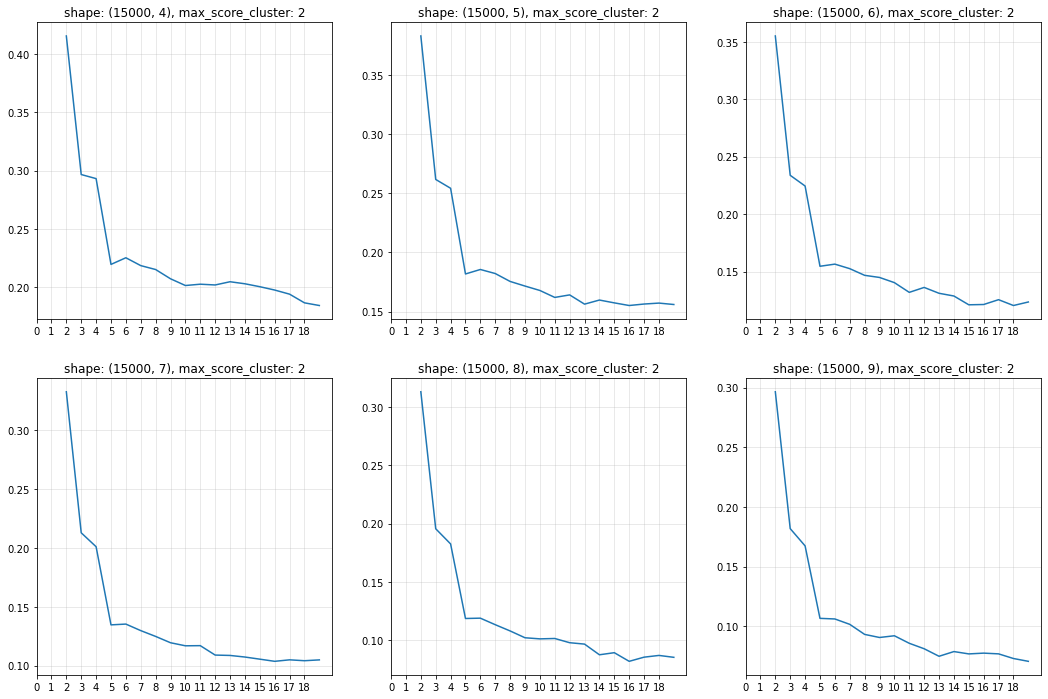

In [304]:
n_components_range = range(4,15)
n_clusters_range =range(2,20)

draw_sil_score_n_components(df_uf_scaled, range_n_clusters=n_clusters_range, n_components=n_components_range)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [01:54<00:00,  8.15s/it]



 shape: (15000, 17), max_score_cluster: 2


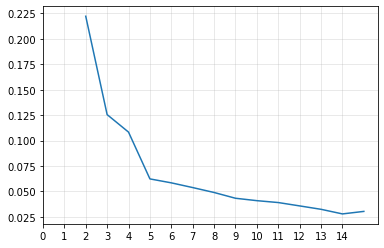

In [276]:
draw_sil_score(df_uf_scaled, range(2,16))

сумма квадратов расстояний от точек до центроидов кластеров:

In [311]:
inertia = []
N = 20
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_uf_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:00<00:00,  3.17s/it]


PCA


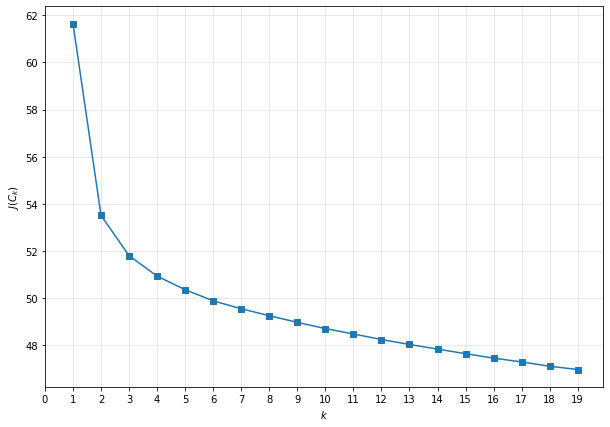

In [312]:
print('PCA')
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')
plt.xticks(range(0, N , 1))
plt.grid(alpha=0.35)
pass

Наиболее подходящее число кластеров 3,4,5,6

In [32]:
clf = KMeans(n_clusters=3)
clf.fit(df_uf_pca)

KMeans(n_clusters=3)

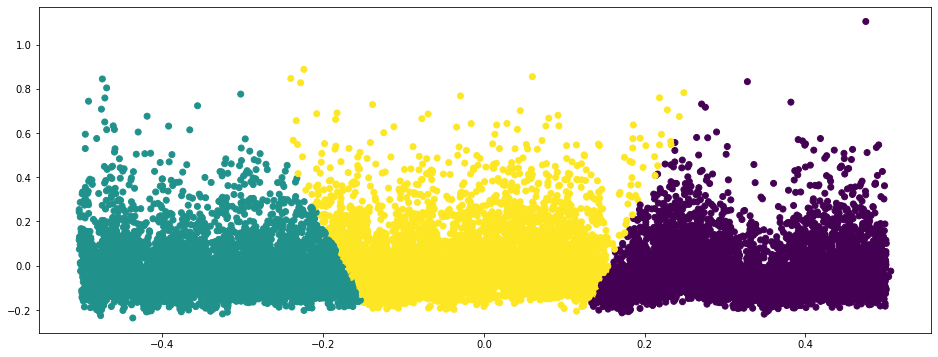

In [33]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [34]:
clf = KMeans(n_clusters=4)
clf.fit(df_uf_pca)

KMeans(n_clusters=4)

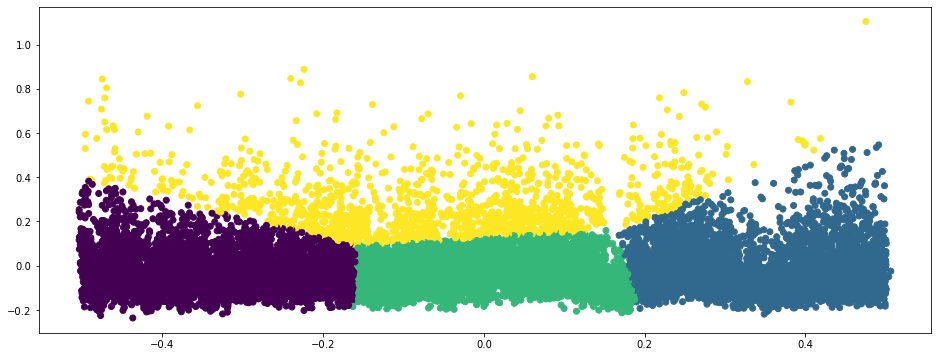

In [35]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [36]:
clf = KMeans(n_clusters=5)
clf.fit(df_uf_pca)

KMeans(n_clusters=5)

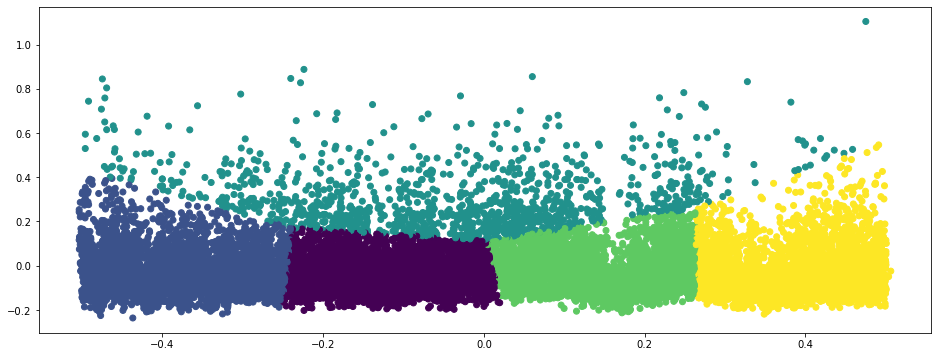

In [37]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

In [38]:
clf = KMeans(n_clusters=6)
clf.fit(df_uf_pca)

KMeans(n_clusters=6)

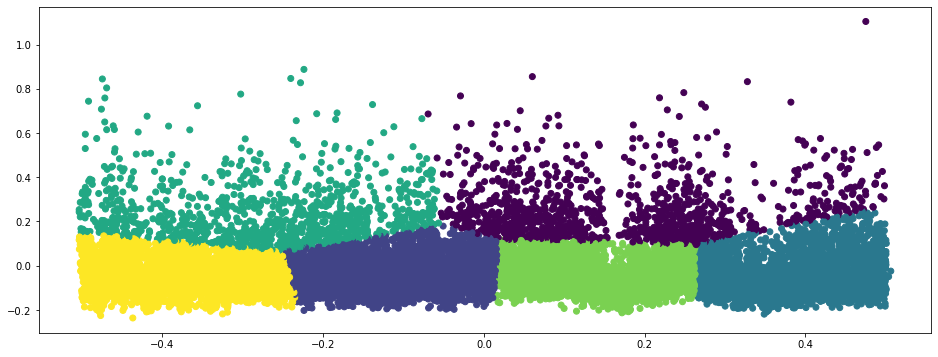

In [39]:
plt.figure(figsize=(16,6))
plt.scatter(df_uf_pca[:,0], df_uf_pca[:,1],c=clf.labels_)

Подготовка к предсказанию

In [40]:
#Добавлю новые столбцы с кластерами
for n in range(3,7):
    clf = KMeans(n_clusters=n)
    clf.fit(df_uf_pca)
    df_uf['Kmeans{}'.format(n)] = clf.labels_

In [41]:
df_uf

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,Kmeans3,Kmeans4,Kmeans5,Kmeans6
0,0,0.959484,0.024890,0.119709,0.083119,0.049700,0.032604,-0.049732,0.005637,0.120104,...,0.085036,0.084546,-0.024835,-0.038055,-0.045251,0.053042,1,1,1,1
1,1,0.968620,-0.035631,0.046282,0.045676,0.114160,0.018050,-0.003364,-0.032724,-0.076289,...,-0.077599,0.106774,0.061935,-0.015028,-0.106559,-0.003852,1,1,1,1
2,2,0.933710,0.030084,-0.039121,0.116893,0.130813,0.171836,0.030485,-0.054120,-0.056811,...,0.160973,0.109083,0.009491,0.127983,0.063371,0.003180,1,1,1,1
3,3,0.962006,-0.030586,-0.188485,0.012392,0.031410,0.057475,0.056365,-0.046878,0.029630,...,-0.016992,-0.051303,-0.071980,-0.006859,0.095798,-0.034290,1,1,1,1
4,4,0.967180,0.095349,-0.036897,-0.048526,-0.009786,0.035573,0.009612,0.097665,-0.103747,...,-0.052034,0.091168,0.069708,0.046377,0.068546,0.040315,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,0.966245,-0.004858,-0.091720,-0.069360,0.039728,-0.106269,0.037242,-0.028344,0.028944,...,-0.068776,-0.043444,-0.085307,-0.082159,0.065187,0.094524,0,0,3,2
14996,14996,0.834114,0.196918,0.067103,0.128018,0.326857,-0.049361,0.024620,0.005111,-0.029306,...,0.060534,0.105334,0.074484,0.244668,0.175922,0.148947,0,0,3,3
14997,14997,0.922118,0.032624,-0.079825,-0.071931,0.067914,-0.045672,0.073827,-0.084630,-0.242422,...,0.004221,-0.007509,0.002010,0.229047,0.013220,0.070915,0,0,3,2
14998,14998,0.986416,-0.069737,-0.009517,-0.015144,-0.064791,0.036025,-0.018166,-0.039688,0.049517,...,0.068509,0.011268,0.018774,-0.068602,0.035840,-0.017300,0,0,3,2


Посмотрим на тех, кто мало открывал статей на сайте, в одном ли они кластере?

In [42]:
df_item_gt1.sum(axis=1).sort_values()

1051      1
13272     2
3411      3
11196     3
344       3
         ..
5726     64
4046     64
11217    64
9914     64
1192     65
Length: 15000, dtype: int64

In [43]:
df_uf[df_uf['user_id'] == 1051]['Kmeans5']

1051    1
Name: Kmeans5, dtype: int32

In [44]:
df_uf[df_uf['user_id'] == 13272]['Kmeans5']

13272    4
Name: Kmeans5, dtype: int32

In [45]:
df_uf[df_uf['user_id'] == 3411]['Kmeans5']

3411    4
Name: Kmeans5, dtype: int32

In [46]:
df_uf[df_uf['user_id'] == 11196]['Kmeans5']

11196    4
Name: Kmeans5, dtype: int32

In [47]:
df_uf[df_uf['user_id'] == 344]['Kmeans5']

344    1
Name: Kmeans5, dtype: int32

Сколько просмотров в каждом кластере=1

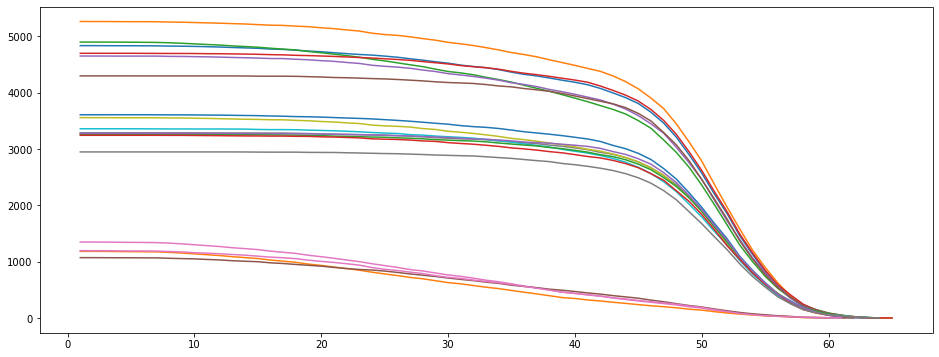

In [48]:
for n in range(3,7):
    for k in range(n):
        user_id_tmp = df_uf[df_uf['Kmeans{}'.format(n)] == k]['user_id'].values
        data = df_train[df_train['user_id'].isin(user_id_tmp)]
        df_tt_k_tmp = pd.DataFrame(data.pivot_table(index='item_id'
                                                    , columns='order'
                                                    , aggfunc='count'
                                                    , fill_value=0).to_records())
        df_tt_k_tmp.columns = list(range(0,len(df_tt_k_tmp.columns),1))
        df_tt_k_tmp.drop(0, axis=1, inplace=True)
        df_tt_k_tmp.sum().plot(figsize=(16,6))

В каждых кластерах просматриваются все order, но меняется количество просмотров и у всех после 45 order наблюдается резкие снижение количества просмотров или снижается наличие данных по просмотрам.  
Не вижу чтобы пользователи, у которых очень мало просмотров (<100) отделялись бы в отдельный кластер. Это говорит о том, что данные из таблицы user-features не характеризуют пользователей по количеству просмотров.


А какие пользователи вообще в тестовых данных? Есть там ИД которыех нет в обучающей выборке?

In [49]:
set(df_test['user_id']) - set(df_train['user_id'])

set()

Все пользователи есть и в трейне и в тесте

Таблица, где в строках пользователи, в столбцах ИД статей а в данных порядок в котором пользователь открывал статьи. Если не смотрел то -1

In [50]:
df_train_X = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_train_X.drop('user_id', axis=1, inplace=True)
df_train_X.columns = list(range(0,len(df_train_X.columns),1))

df_train_X

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,2,3,4,5,6,7,8,9,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,29,32,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,43,4,24,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,21,-1,13,45,11,-1,31,33,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,12,-1,-1,46,44,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,47,38,-1,12,6,1,-1,31,-1,-1,...,18,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,-1,15,27,8,33,19,-1,20,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,-1,-1,-1,-1,-1,10,40,12,-1,-1,...,-1,-1,37,25,-1,-1,-1,-1,-1,-1
14998,-1,-1,-1,20,-1,-1,10,5,51,-1,...,37,-1,-1,-1,-1,-1,15,-1,-1,-1


Таблица, где в строках пользователи, в столбцах порядок просмотра статей пользователем, а в данных ИД статьи. Если не смотрел то -1

In [51]:
df_train_X_order = pd.DataFrame(df_train.pivot_table(index='user_id', columns='order', values='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_train_X_order.drop('user_id', axis=1, inplace=True)
df_train_X_order

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,0,1,2,3,4,5,6,7,8,9,...,55,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,63,53,66,10,42,67,27,47,17,21,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,7,14,58,3,27,65,48,63,17,94,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,116,117,44,115,33,57,34,19,46,47,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,1,65,126,127,27,31,120,110,26,51,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,5,98,44,52,141,4,152,81,29,73,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,150,90,57,81,24,27,101,3,17,114,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,26,22,57,62,19,110,92,56,34,5,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14998,33,116,66,108,7,32,25,13,47,6,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Разделю пользователей по количеству просмотренных статей

In [52]:
df_view_count = pd.DataFrame(df_train.pivot_table(index='user_id', columns='order', values='item_id', 
                                                aggfunc='count', fill_value=0).to_records())
df_view_count.drop('user_id', axis=1, inplace=True)
df_view_count

,1,2,3,4,5,6,7,8,9,10,...,56,57,58,59,60,61,62,63,64,65
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14996,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14997,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14998,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_view_count['view_count'] = df_view_count.sum(axis=1).values

In [107]:
n=15
df_view_count['view_q'] = pd.qcut(df_view_count['view_count'], q=n, precision=0, labels=range(n))

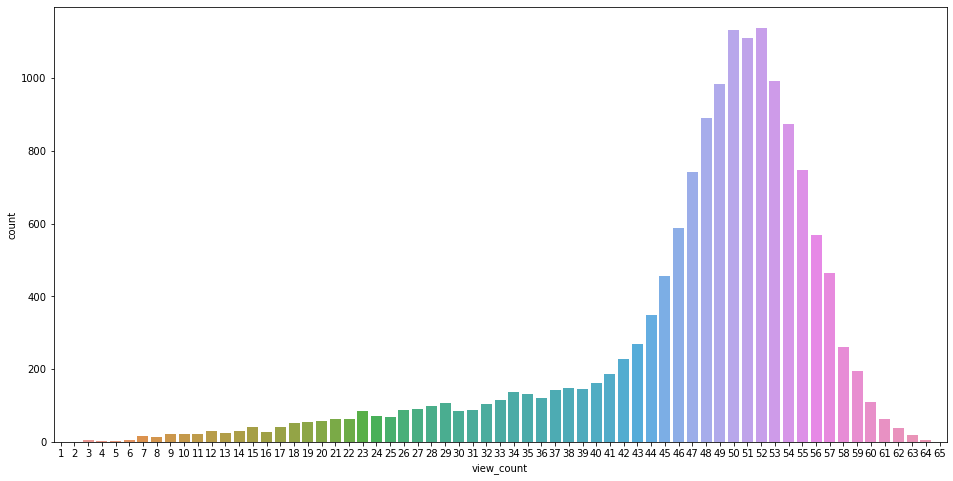

In [108]:
plt.figure(figsize=(16,8))
sns.countplot(df_view_count['view_count'])

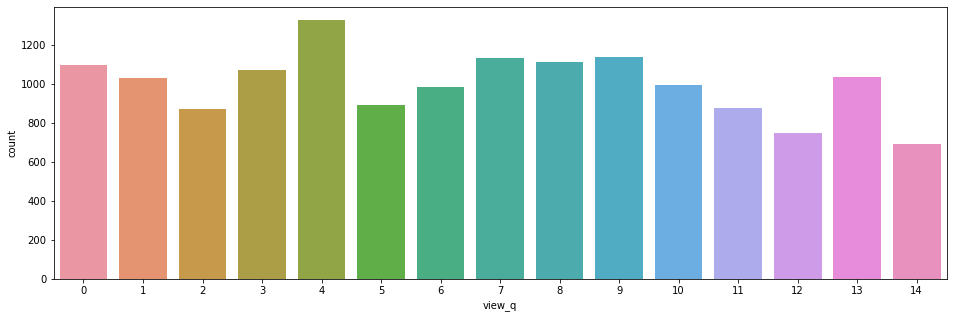

In [109]:
plt.figure(figsize=(16,5))
sns.countplot(df_view_count['view_q'])

Рейтинги статей (количество просмотров поделенные на количество пользователей)

In [ ]:
df_item_id_rate = pd.DataFrame(df_train.pivot_table(index='item_id', columns='user_id', values='order', 
                                                aggfunc='count', fill_value=0).to_records())
df_item_id_rate.drop('item_id', axis=1, inplace=True)
df_item_id_rate

In [123]:
df_item_id_rate['item_rate'] = df_item_id_rate.sum(axis=1).values / len(df_train['user_id'].unique())

In [137]:
df_item_id_rate[['item_rate']]

,item_rate
0,0.108733
1,0.617933
2,0.228600
3,0.742133
4,0.731533
...,...
186,0.077333
187,0.112067
188,0.080933
189,0.081133


#### Валидационная выборка

В качестве валидационной выборки возьму 3 последних посещения у каждого пользователя.  
Тех пользователей у которых меньше N посещений пока уберу в сторону

In [165]:
df_valid = pd.DataFrame(columns=['user_id', 'order', 'item_id'])
df_valid

,user_id,order,item_id


In [211]:
valid_ui = [] # user_id
valid_o = []  # order
valid_i = []  # item_id
train_index = []  # индексы чтрок из тренировочной выборке, которые станут валидационным
bad_users_id = [] # ид пользователей где меньше 4 посещений

for u_id in df_train['user_id'].unique():
    u_items_valid = df_train[df_train['user_id'] == u_id]['item_id'][-4:]
    if len(u_items_valid) > 3: #если есть хотябы 4 посещения (1-для прездсказания следущих, 3-для валидации)   
        order = 0
        for index, item in u_items_valid[-3:].items(): #беру 3 последних посещения для каждого пользователя
            order+=1
            valid_ui.append(u_id)
            valid_o.append(order)
            valid_i.append(item)
            train_index.append(index)
    else:
        bad_users_id.append(u_id)

In [212]:
df_valid['user_id'] = valid_ui
df_valid['order'] = valid_o
df_valid['item_id'] = valid_i

In [213]:
bad_users_id

[344, 1051, 3411, 5611, 11196, 13272]

In [214]:
df_valid

,user_id,order,item_id
0,0,1,53
1,0,2,54
2,0,3,55
3,1,1,90
4,1,2,23
...,...,...,...
44977,14998,2,8
44978,14998,3,24
44979,14999,1,160
44980,14999,2,49


Теперь нужно вычистить валидационные данные из тренировочных, сформирую новую тренировочную выборку.  
Для этого объединю валидационные данные с тренировочными и удалю дубликаты, тем самым в тренировочных данных останутся только не повторяющиеся значения.

In [219]:
df_train_sh = df_train.drop(train_index )

In [220]:
print('Тренировочные данные ({}) - валидационные ({}) = ({}). Новые тренировочные = ({})'.format(
                    df_train.shape[0], df_valid.shape[0], df_train.shape[0]-df_valid.shape[0], df_train_sh.shape[0]))

Тренировочные данные (705066) - валидационные (44982) = (660084). Новые тренировочные = (660084)


### Метрика качества

В качестве метрики для оценивания качества используется метрика ранжирования mean average precision at k (MAP@k) при k=3. То есть в метрике будут участвовать только 3 первых предсказания. На лидерборде показывается метрика умноженная на 10000, то есть результат будет выглядеть как 10000 * MAP@k.

Расчет данной метрики можно представить в три этапа:

1. Считаем precision at k:

Precision@k= 1/k ∑i=0 to k(Yitrue==Yipred)
2. Считаем average precision at k:

AP@k= 1/k ∑i=0 to k(Yitrue==Yipred)∗Precision@i
3. Берем среднее от average precision at k:

MAP@k= 1/N ∑i=0 to N (AP@k)
Чтобы реализовать данную функцию локально можно использовать следующий алгоритм.

На вход нам приходят два pd.DataFrame gt и preds с колонками [user_id, item_id, order]. gt – ground truth, то есть настоящие данные, а preds – наши предсказания. Тогда мы можем использовать следующие шаги для расчета метрики.

1. Отфильтровать gt и preds по колонке order, чтобы его значение было не больше k (порядка k в MAP@k).

2. Сджойнить два датафрейма по user_id и order. Здесь нам важно сохранить информацию о том, какой item_id на каком месте был для каждого пользователя.

После этих шагов мы готовы к расчету метрик по трем вышеописанным шагам для расчета MAP@k

3. Добавим в объединенный датафрейм (joined) колонку is_right, показывающую, что на текущем месте ответ был правильным. 4. Так как для расчета precision@k нам нужно знать количество всех правильных событий до текущего момента, то посчитаем кумулятивную сумму колонки is_right в разрезе по пользователям. Назовем ее is_right_cum.

5. Теперь посчитаем precision@k поделив колонку is_right_cum на order. То есть разделим количество правильно угаданных событий на количество всех событий до текущего момента.

6. В AP@k участвуют только те precision@k, для которых в текущий момент времени был правильно угадан ответ. Поэтому мы можем добавить еще одну колонку p@k_masked, которая является перемножением p@k на is_right.

7. Посчитаем среднее в разрезе каждого пользователя по колонке p@k_masked, получим AP@k для каждого пользователя.

8. Теперь возьмем глобальное среднее по AP@k и получим итоговую метрику MAP@k.

In [222]:
def calc_map_k(gt: pd.DataFrame, preds: pd.DataFrame, k=3) -> float:
    # filter first k elements of ground truth
    gt = gt[gt.order <= k]
    # filter first k elements of predictions
    preds = preds[preds.order <= k]
    # join ground truth and predictions by user_id and order, fill missed values from predictions by some non-existent value
    joined = gt.merge(preds, how="left", on=['user_id', "order"]).fillna(-12345)
    # create indicator of right predictions
    joined["is_right"] = (joined.item_id_x == joined.item_id_y).astype(int)
    # calculate cumulative sum of all right predictions before current order
    joined["is_right_cum"] = joined.groupby("user_id").is_right.cumsum()
    # normalize it by order (precision@k)
    joined["p@k"] = joined["is_right_cum"] / joined["order"]
    # add relevance mask
    joined["p@k_masked"] = joined["p@k"] * joined["is_right"]
    # calculate mean user based (average precision @ k)
    ap = joined.groupby("user_id")["p@k_masked"].mean()
    # calculate mean average precision @ k
    return ap.mean()

Проверка:

In [545]:
calc_map_k(df_valid, df_valid) *1000

1000.0

### baseline

В качестве бейзлайна буду для каждого пользователя брать его последнее посещение, выбирать всех пользователей кто посещал такую же статью, выбирать следующую статью которые посетили другие пользователи, выбирать из них самую популярную (по количеству посещений), вычищать из ниж ид статей которые уже просмотрел пользователь (т.к. по вбыорке я знаю что 2 раза пользователи не смотрят одну и ту же статью) и то что осталось то и рекомендовать.

Пример для пользователя с ИД = 0

In [246]:
user0_last_item_id = df_train_sh[df_train_sh['user_id'] == 0][-1:]["item_id"].values[0]
print("последняя просмотренная статья:{}".format(user0_last_item_id))

последняя просмотренная статья:52


In [251]:
#статьи которые уже просмотрел
user0_show_item_id = df_train_sh[df_train_sh['user_id'] == 0]["item_id"].values
len(user0_show_item_id)

53

In [253]:
user0_show_item_id

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int64)

Пользователь с ИД = 3 тоже смотрел 52 статью

In [249]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
189,3,52,30


In [303]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
189,3,52,30


А после нее он смотрел статью с ИД 7, но она уже есть в просмотренных пользователем 0, значит не подходит

In [250]:
df_train_sh[(df_train_sh['user_id'] == 3) & (df_train_sh['order'] == 31)]

,user_id,item_id,order
190,3,7,31


In [264]:
7 in user0_show_item_id

True

А вот пользователь с ИД 9 после 52 смотрел 53, это подходит.

In [335]:
df_train_sh[(df_train_sh['user_id'] == 9) & (df_train_sh['item_id'] == user0_last_item_id)]

,user_id,item_id,order
565,11,52,33


In [261]:
df_train_sh[(df_train_sh['user_id'] == 9) & (df_train_sh['order'] == 17)]

,user_id,item_id,order
472,9,53,17


In [266]:
53 in user0_show_item_id

False

Есть пользователи которые смотрят статьи по очереди по ИД статьи (1,2,3 и т.д.), например пользователь с ИД 0. Для таких пользователей явно нужно рекомендовать просто следующую по порядку.  
Стоит поискать пользователей у которых серия последних просмотренных статей по порядку к примеру N(3,5,10) и для них рекомендовать просто следующую.

Можно еще попробовать обучить какую то модель которая сможет по ряду пользователя определеять следующее число, как у пользователя 0 где линейная завсимость.

Матрица пользователей и просмотренных статей.  
По ней буду отбирать ИД пользователей которые смотрели такую же статью.

In [594]:
df_user_item = pd.DataFrame(df_train.pivot_table(index='user_id', columns='item_id', 
                                                aggfunc='sum', fill_value=-1).to_records())
df_user_item .drop('user_id', axis=1, inplace=True)
df_user_item.columns = list(range(0,len(df_train_X.columns),1))

df_user_item

,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1,2,3,4,5,6,7,8,9,10,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,29,32,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,43,4,24,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,21,-1,13,45,11,-1,31,33,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,1,-1,-1,12,-1,-1,46,44,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,47,38,-1,12,6,1,-1,31,-1,-1,...,18,-1,-1,-1,-1,-1,-1,-1,-1,-1
14996,-1,15,27,8,33,19,-1,20,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
14997,-1,-1,-1,-1,-1,10,40,12,-1,-1,...,-1,-1,37,25,-1,-1,-1,-1,-1,-1
14998,-1,-1,-1,20,-1,-1,10,5,51,-1,...,37,-1,-1,-1,-1,-1,15,-1,-1,-1


In [620]:
k=500
clf = KMeans(n_clusters=k, n_jobs=-1)
clf.fit(df_uf_pca)
df_uf['Kmeans{}'.format(k)] = clf.labels_

In [628]:
k=500
clf = KMeans(n_clusters=k, n_jobs=-1)
clf.fit(df_user_item)
df_uf['Kmeans{}'.format(k)] = clf.labels_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [629]:
%%time
o=3 #количетсво требуемых рекомендаций
#df_pred_valid = df_valid.copy().drop('item_id', axis=1)
users_idx = df_pred_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    next_rec = True # флаг, нужно ли давать следующую рекомнедацию
    user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans500'].values[0] #смотрим в каком кластере текущий юзер
    users_in_cluster = df_uf[df_uf['Kmeans6'] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций
        recomendet_id = []  
        if (next_rec):
            users_idx_item = df_user_item[df_user_item[user_last_item_id]!=-1][user_last_item_id] #пользователи которые смотрели такую же статью
            users_pool = set(users_idx_item) & set(users_in_cluster) #оставляю только юзеров из того же кластера
            users_pool = set(users_idx_item) - set([user_id]) #минус текущий пользователь
            for show_user_id in users_pool: #прохожу по всем пользователям кроме текущего
                show_data = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                        (df_train_sh['item_id'] == user_last_item_id)]
                if show_data.shape[0] > 0: #если обрабатываемый пользователь смотрел такую же статью
                    next_show = df_train_sh[(df_train_sh['user_id'] == show_user_id) & 
                                            (df_train_sh['order'] == show_data['order'].values[0] + 1)]
                    if next_show.shape[0] > 0: #если есть инфа о статье которую пользователь смотрел следующей
                        recomendet_id.append(next_show['item_id'].values[0]) #то сохраняем ее в список рекомендаций
        if len(recomendet_id) > 0: #если есть рекомендации
            df_rec = pd.DataFrame(recomendet_id, columns=['rec'])
            top_rec = df_rec['rec'].value_counts().sort_values(ascending=False) #группируем рекомендуемые статьи и сортируем по популярности
            df_top_rec = pd.DataFrame()
            df_top_rec['item_id'] = top_rec.index
            df_top_rec['count'] = top_rec.values
            df_top_rec = df_top_rec[~df_top_rec['item_id'].isin(user_show_item_id)] #отбираю рекомендации кроме просмотренных статей
            if(df_top_rec.shape[0]>0):
                top1_rec = df_top_rec.iloc[0][0] #топ 1 рекомендация
                user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
                user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную
            else:
                top1_rec = -1
                next_rec = False # все рекомендации для этого пользователя сразу -1
                print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    
            recomendaciones.append(top1_rec)
            #print('рекомендация: ({}-{})'.format(order, top1_rec)) #топ 1 рекомендация
        else:
            next_rec = False # все рекомендации для этого пользователя сразу -1
            recomendaciones.append(-1)
            print('!!! нет рекомендации для пользователя:({}), статьи ({}), order ({})'.format(user_id, user_last_item_id, order))    

  0%|                                                                              | 3/14994 [00:02<3:34:54,  1.16it/s]

!!! нет рекомендации для пользователя:(2), статьи (157), order (3)


  1%|▌                                                                            | 99/14994 [01:32<3:38:39,  1.14it/s]

!!! нет рекомендации для пользователя:(98), статьи (99), order (2)
!!! нет рекомендации для пользователя:(98), статьи (99), order (3)


  1%|▌                                                                           | 112/14994 [01:45<3:54:23,  1.06it/s]


KeyboardInterrupt: 

Если пользователь смотрел уже все статьи которые мы рекомендуем ему на этой итерации, то нужно рекомендовать следуюущую после той котороую он сомтрел недавно, т.е. +1 к ней. Это нужно делать перебором из оставшихся статей до максимума. Либо рекомендовать топовую статью.

In [ ]:
#на первых 100 пользователях!
#кластеры kmeans=500 18.3531746031746
#без кластеров 19.576719576719576

In [750]:
%%time
# Тут выставляю в качестве рекомендации последнюю просмотренную статью + 1

o=3 #количетсво требуемых рекомендаций
#df_pred_valid = df_valid.copy().drop('item_id', axis=1)
users_idx = df_pred_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    #next_rec = True # флаг, нужно ли давать следующую рекомнедацию
    #user_id_cluster = df_uf[df_uf['user_id'] == user_id]['Kmeans500'].values[0] #смотрим в каком кластере текущий юзер
    #users_in_cluster = df_uf[df_uf['Kmeans6'] == user_id_cluster]['user_id'].values #все юзеры в этом кластере
    for order in range(1, o+1): #по кличеству необходимых рекомендаций
        find = False
        for show_item in user_show_item_id :
            top1_rec = user_last_item_id + 1
            if top1_rec in user_show_item_id:
                top1_rec += 1
            else:
                find = True
                break
        if find == False:
            top1_rec = -1
        recomendaciones.append(top1_rec)
        user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию

100%|███████████████████████████████████████████████████████████████████████████| 14994/14994 [00:49<00:00, 301.39it/s]

Wall time: 49.8 s


In [645]:
#последняя просмотренная статья + 1     4.431402190505839  

In [658]:
df_item_top = pd.DataFrame(df_train.pivot_table(index='item_id', columns='order', 
                                                aggfunc='count', fill_value=0).to_records())
df_item_top.drop('item_id', axis=1, inplace=True)
df_item_top.columns = list(range(0, 65,1))

df_item_top

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,23,54,90,47,38,33,43,39,32,28,...,7,5,4,2,1,0,0,0,1,0
1,158,242,228,265,218,189,218,247,236,225,...,13,11,7,3,4,2,0,0,0,0
2,40,54,64,79,64,57,45,54,58,56,...,11,8,4,3,0,2,0,0,0,0
3,241,344,329,299,286,289,321,304,282,315,...,19,8,7,0,2,1,0,0,0,0
4,223,290,282,290,275,285,294,288,286,276,...,18,9,9,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,14,10,18,21,22,10,10,15,27,21,...,0,1,2,0,0,1,0,0,0,0
187,14,35,27,25,19,32,20,22,27,21,...,5,3,3,4,0,0,0,0,0,0
188,16,41,13,21,10,15,16,21,11,15,...,2,0,1,2,2,1,1,0,0,0
189,5,13,21,19,20,7,19,12,18,26,...,5,3,3,3,1,1,0,0,0,0


In [711]:
top_items = df_item_top.sum(axis=1).sort_values(ascending=False).index[:100]

In [720]:
%%time
# Тут выставляю в качестве рекомендации топовую статью, но не просмотренную пользователем
o=3 #количетсво требуемых рекомендаций
users_idx = df_pred_valid['user_id'].unique()
recomendaciones = [] #рекомендации

for user_id in tqdm(users_idx): #иду по всем пользователям   
    user_show_item_id = df_train_sh[df_train_sh['user_id'] == user_id]["item_id"].values #все просмотренные статьи пользователя
    #user_last_item_id = df_train_sh[df_train_sh['user_id'] == user_id][-1:]["item_id"].values[0] #последняя просмотренная статья пользователя
    for order in range(1, o+1): #по кличеству необходимых рекомендаций    
        for top_item in top_items:
            if top_item not in user_show_item_id:
                top1_rec = top_item
                break
        recomendaciones.append(top1_rec)
        #user_last_item_id = top1_rec #сохраняем в качестве статьи для которой будем давать следующую рекомендацию
        user_show_item_id = np.append(user_show_item_id, top1_rec)#сохраняем рекомендованную статью как просмотренную

100%|███████████████████████████████████████████████████████████████████████████| 14994/14994 [00:28<00:00, 527.46it/s]

Wall time: 28.4 s


In [737]:
#рекомендовать всегда топ статью    22.779482163235482

Метрика:

In [752]:
df_valid_tmp = df_valid[:len(recomendaciones)].copy()

In [753]:
df_valid_tmp['item_id'] = recomendaciones

In [754]:
df_valid_tmp.head()

,user_id,order,item_id
0,0,1,53
1,0,2,54
2,0,3,55
3,1,1,90
4,1,2,91


In [755]:
calc_map_k(df_valid[:len(recomendaciones)], df_valid_tmp) *1000

4.249848087383108

### ALS

In [756]:
#n_factors = 2-256
#n_iters = 5=50

In [ ]:
model = implicit.als.AlternatingLeastSquares(factors=16, regularization=0.0, iterations=8)

In [ ]:
model.fit(X.T) #важно транспонировать, нужно чтобы была матрица продукты*пользователи

row_sparse - пользователи или один (вектор данных)
N=30 - сколько товаров рекомендуем
filter_alredy_liked_items=False - не исключать из рекомендации товары которые он покупал раньше
recalculate_user=True - пересчитать матрицу в модели если это новый пользователь

Для преобразования Ид продуктов которые рекомендует модель в реальные продукты есть product_encoder.toPid()